In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18, 12]

import matplotlib.pyplot as plt
from mne.io import read_raw_edf, concatenate_raws
from mne.datasets import eegbci
from mne import find_events, pick_channels, Epochs, pick_types, compute_covariance
from mne.filter import create_filter
from mne.preprocessing import create_eog_epochs
from mne.viz import plot_cov
import numpy as np

import sys

In [2]:
subject = 1
runs = [6, 10, 14]

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in raw_fnames]
raw = concatenate_raws(raw_files)
raw.rename_channels(lambda x: x.strip('.'))

Extracting EDF parameters from /Users/liabanzh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from /Users/liabanzh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /Users/liabanzh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
S

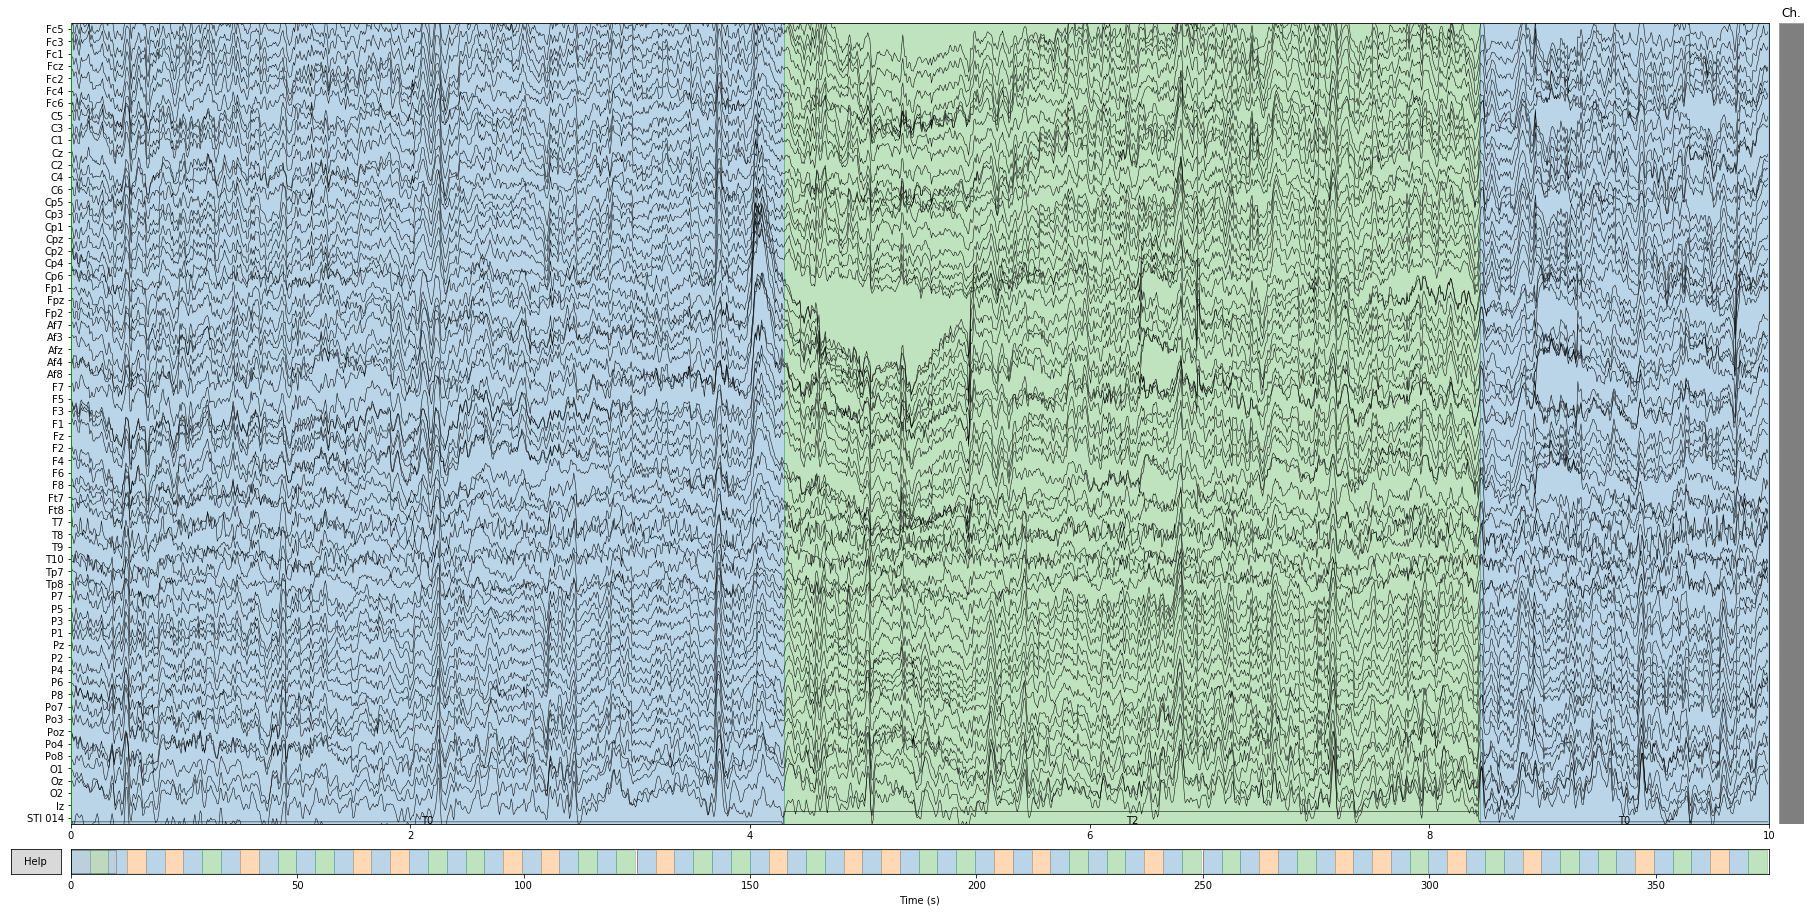

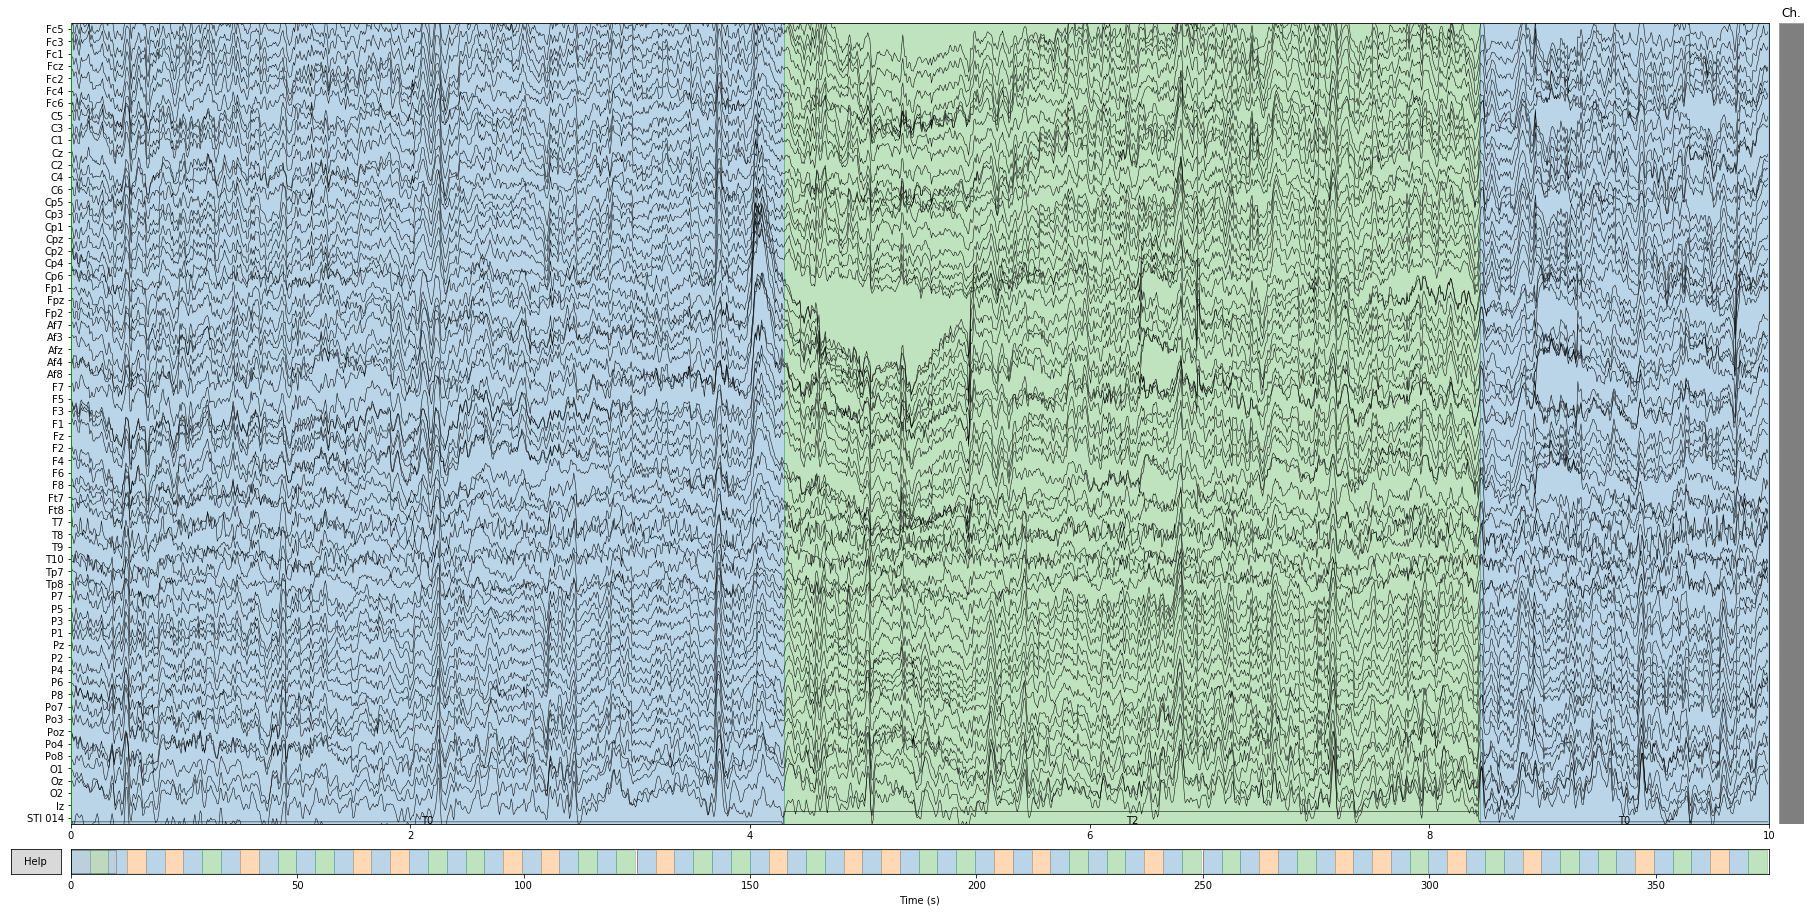

In [3]:
raw.plot(n_channels=65, title='Raw data ploting', show=True, block=True)

In [4]:
FREQ = 160 # Hz

filtered = raw.filter(1., 59.) # band-pass filter

Setting up band-pass filter from 1 - 59 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 14.8 Hz
Filter length of 529 samples (3.306 sec) selected
Setting up band-pass filter from 1 - 59 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 14.8 Hz
Filter length of 529 samples (3.306 sec) selected
Setting up band-pass filter from 1 - 59 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 14.8 Hz
Filter length of 529 samples (3.306 sec) selected


In [5]:
tmin, tmax = -1, 1  # define epochs around events (in s)
event_ids = dict(none=1, hands=2, feet=3)  # map event IDs to tasks
reject = dict(eeg=2e-6) # artefact threshold

events = find_events(filtered, stim_channel='STI 014')
epochs = Epochs(filtered, events, event_id=event_ids, tmin=tmin, tmax=tmax, baseline=None, preload=True)

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
71 events found
Event IDs: [1 2 3]
71 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 71 events and 321 original time points ...
0 bad epochs dropped


In [6]:
from mne.preprocessing import ICA

ica = ICA(n_components=1., method='fastica').fit(epochs)
ica_components = ica.get_components()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 64 components
Fitting ICA took 4.6s.


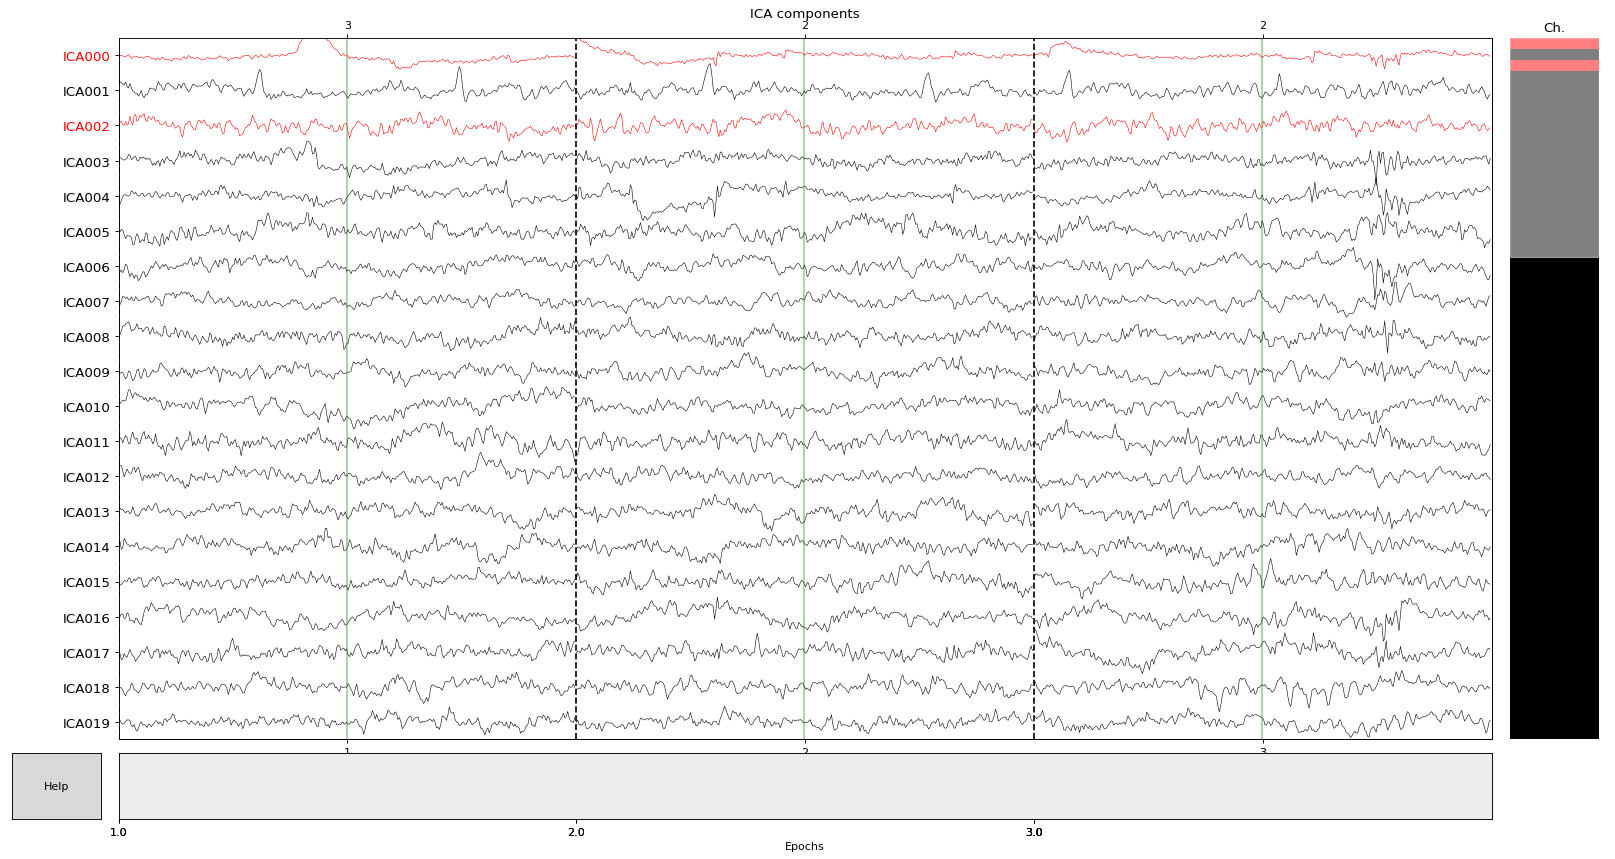

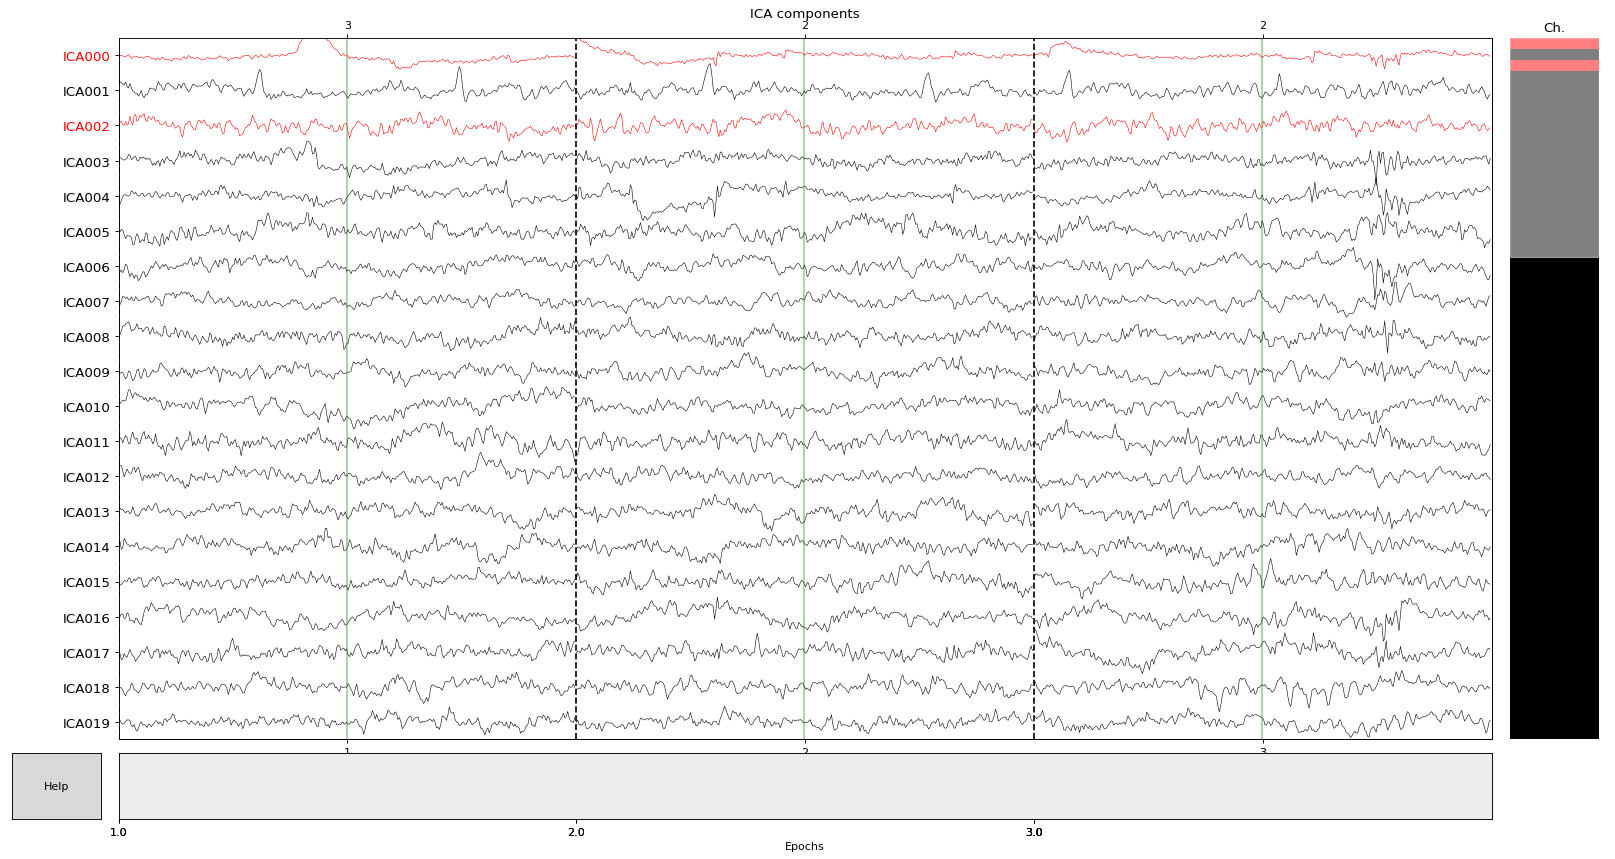

In [7]:
ica.exclude = [0,2]
ica.plot_sources(epochs[:3])

In [8]:
import numpy as np

# Infomax

class ft_ICA:
    def __init__(self, n_components):
        self.n = n_components
        self.W = np.zeros(shape=(n_components, n_components))
        
    def _center(self, X):
        X_now = np.array(X)
        
        return X_now - X_now.mean(axis=1, keepdims=True)
    
    def _white_components(self, X):
        X_curr = np.array(X)
        X_cov = np.cov(X_curr)
        
        d, E = np.linalg.eigh(X_cov)
        D = np.diag(d)
        D_inv = np.sqrt(np.linalg.inv(D))
        X_clean = np.dot(E, np.dot(D_inv, np.dot(E.T, X_curr)))
        
        return X_clean
    
    def fit(self, X):
        X = self._center(X)
        X = self._white_components(X)
        
        return X

In [16]:
ica2 = ft_ICA(64)

X_data = epochs[0].get_data()[0][:64]

ica2._white_components(X_data)

array([[ 1.04353525,  0.16769984, -0.18067612, ...,  0.87313112,
         1.19419128,  1.19224052],
       [ 0.48321351, -0.05131213,  0.31873005, ...,  0.19358117,
         0.00906863,  1.16929793],
       [ 0.46135405,  1.22661769,  1.2523552 , ..., -0.42170216,
        -0.34056578, -1.24949365],
       ...,
       [ 0.61532483, -0.2863579 , -0.35952331, ..., -0.20411983,
        -0.66145327, -1.00839538],
       [ 0.2951762 ,  0.30574101, -0.35051954, ..., -0.99006577,
        -0.2172441 , -0.22751645],
       [ 2.96495149,  2.46345979,  0.71211134, ...,  0.61557497,
         0.79884237,  0.39612799]])

In [15]:
X_data

array([[ 3.91969966e-05,  1.96386703e-05,  2.17051649e-05, ...,
        -5.30288639e-06, -1.11820592e-05, -8.94240418e-06],
       [ 4.29487928e-05,  2.94264123e-05,  3.23615028e-05, ...,
        -1.04311576e-05, -2.06518496e-05, -1.68544620e-05],
       [ 4.39113788e-05,  3.46507811e-05,  3.40105727e-05, ...,
        -2.17777066e-05, -3.61692729e-05, -3.42161693e-05],
       ...,
       [ 5.99275330e-05,  4.33989859e-05,  3.34741105e-05, ...,
        -3.82740005e-05, -2.86913730e-05, -2.55676733e-05],
       [ 9.53897763e-05,  7.06870642e-05,  4.69758564e-05, ...,
         1.03708083e-05,  1.17602820e-05,  1.29264450e-05],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         3.00000000e+00,  3.00000000e+00,  3.00000000e+00]])